# Test Measured Throughput Anomaly Detection Model

## Imports

In [1]:
import tensorflow as tf
import pandas as pd # for data manipulation 
import numpy as np
import glob, math, os
from scipy import special
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.models import Model

def euclidean_dist(row):
    # Function to calc euclidean distance on every df row 
    euc_dist = math.sqrt(row["U2G_Distance"]**2 - row["Height"]**2)
    return euc_dist

def q_func(x):
    q = 0.5 - 0.5*special.erf(x / np.sqrt(2))
    return q

def friis_calc(P,freq,dist,ple):
    '''
    Friis path loss equation
    P = Tx transmit power
    freq = Signal frequency
    dist = Transmission distance
    ple = Path loss exponent
    '''
    propagation_speed = 299792458
    l = propagation_speed / freq
    h_pl = P * l**2 / (16*math.pi**2)
    P_Rx = h_pl * dist**(-ple)
    return P_Rx

def plos_calc(h_dist, height_tx, height_rx, env='suburban'):
    '''
    % This function implements the LoS probability model from the paper
    % "Blockage Modeling for Inter-layer UAVs Communications in Urban
    % Environments" 
    % param h_dist    : horizontal distance between Tx and Rx (m)
    % param height_tx : height of Tx
    % param height_rx : height of Rx
    '''
    if env == 'suburban':
        a1 = 0.1
        a2 = 7.5e-4
        a3 = 8
    elif env == 'urban':
        a1 = 0.3
        a2 = 5e-4
        a3 = 15
    
    delta_h = height_tx - height_rx
    # pow_factor = 2 * h_dist * math.sqrt(a1*a2/math.pi) + a1 # NOTE: Use this pow_factor if assuming PPP building dist.
    pow_factor = h_dist * math.sqrt(a1*a2) # NOTE: Use this pow_factor if assuming ITU-R assumptions.
    if delta_h == 0:
        p = (1 - math.exp((-(height_tx)**2) / (2*a3**2))) ** pow_factor
    else:
        if delta_h < 0:
            h1 = height_rx
            h2 = height_tx
        else:
            h1 = height_tx
            h2 = height_rx
        delta_h = abs(delta_h)
        p = (1 - (math.sqrt(2*math.pi)*a3 / delta_h) * abs(q_func(h1/a3) - q_func(h2/a3))) ** pow_factor
    return p

def sinr_lognormal_approx(h_dist, height, env='suburban'):
    '''
    To approximate the SNR from signal considering multipath fading and shadowing
    Assuming no interference due to CSMA, and fixed noise
    Inputs:
    h_dist = Horizontal Distance between Tx and Rx
    height = Height difference between Tx and Rx
    env = The operating environment (currently only suburban supported)
    '''
    # Signal properties
    P_Tx_dBm = 20 # Transmit power of 
    P_Tx = 10**(P_Tx_dBm/10) / 1000
    freq = 2.4e9 # Channel frequency (Hz)
    noise_dBm = -86
    noise = 10**(noise_dBm/10) / 1000
    if env == "suburban":
        # ENV Parameters Constants ----------------------------------
        # n_min = 2
        # n_max = 2.75
        # K_dB_min = 7.8
        # K_dB_max = 17.5
        # K_min = 10**(K_dB_min/10)
        # K_max = 10**(K_dB_max/10)
        # alpha = 11.25 # Env parameters for logarithm std dev of shadowing 
        # beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        n_min = 2
        n_max = 2.75
        K_dB_min = 1.4922
        K_dB_max = 12.2272
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 11.1852 # Env parameters for logarithm std dev of shadowing 
        beta = 0.06 # Env parameters for logarithm std dev of shadowing 
        # -----------------------------------------------------------
    elif env == "urban":
        n_min = 1.9
        n_max = 2.7
        K_dB_min = -5
        K_dB_max = 15
        K_min = 10**(K_dB_min/10)
        K_max = 10**(K_dB_max/10)
        alpha = 10.42 # Env parameters for logarithm std dev of shadowing 
        beta = 0.05 # Env parameters for logarithm std dev of shadowing 
    # Calculate fading parameters
    PLoS = plos_calc(h_dist, 0, height, env=env)
    theta_Rx = math.atan2(height, h_dist) * 180 / math.pi # Elevation angle in degrees
    ple = (n_min - n_max) * PLoS + n_max # Path loss exponent
    sigma_phi_dB = alpha*math.exp(-beta*theta_Rx)
    sigma_phi = 10**(sigma_phi_dB/10) # Logarithmic std dev of shadowing
    K = K_min * math.exp(math.log(K_max/K_min) * PLoS**2)
    omega = 1 # Omega of NCS (Rician)
    dist = math.sqrt(h_dist**2 + height**2)
    P_Rx = friis_calc(P_Tx, freq, dist, ple)
    # Approximate L-NCS RV (which is the SNR) as lognormal
    eta = math.log(10) / 10
    mu_phi = 10*math.log10(P_Rx)
    E_phi = math.exp(eta*mu_phi + eta**2*sigma_phi**2/2) # Mean of shadowing RV
    var_phi = math.exp(2*eta*mu_phi+eta**2*sigma_phi**2)*(math.exp(eta**2*sigma_phi**2)-1) # Variance of shadowing RV
    E_chi = (special.gamma(1+1)/(1+K))*special.hyp1f1(-1,1,-K)*omega
    var_chi = (special.gamma(1+2)/(1+K)**2)*special.hyp1f1(-2,1,-K)*omega**2 - E_chi**2
    E_SNR = E_phi * E_chi / noise # Theoretical mean of SINR
    var_SNR = ((var_phi+E_phi**2)*(var_chi+E_chi**2) - E_phi**2 * E_chi**2) / noise**2
    std_dev_SNR = math.sqrt(var_SNR)
    # sigma_ln = math.sqrt(math.log(var_SNR/E_SNR**2 + 1))
    # mu_ln = math.log(E_SNR) - sigma_ln**2/2
    return E_SNR, std_dev_SNR

def normalize_data(df_in, columns, link, save_details_path=None):
    '''
    columns: The pandas data columns to normalize, given as a list of column names
    link is the link type, for choosing the range of measured throughput to scale the data
    '''
    assert link in ["Downlink", "Uplink", "Video"], 'link must be one of "Downlink", "Uplink", "Video"'
    df = df_in.copy()
    # Define the ranges of parametrers
    max_mean_sinr = 10*math.log10(1123) # The max mean SINR calculated at (0,60) is 1122.743643457063 (linear)
    max_std_dev_sinr = 10*math.log10(466) # The max std dev SINR calculated at (0,60) is 465.2159856885714 (linear)
    min_mean_sinr = 10*math.log10(0.2) # The min mean SINR calculated at (1200,60) is 0.2251212887895188 (linear)
    min_std_dev_sinr = 10*math.log10(0.7) # The min std dev SINR calculated at (1200,300) is 0.7160093126585219 (linear)
    max_height = 300
    min_height = 60
    max_h_dist = 1200
    min_h_dist = 0
    max_mcs = 7
    min_mcs = 0
    max_uav_speed = 26
    min_uav_speed = 0
    if link == "Downlink":
        max_throughput = 16000 # Max measured throughput for DJI Spark Downlink is 15968 bytes/sec
    elif link == "Uplink":
        max_throughput = 565000 # Max measured throughput for DJI Spark Uplink is 564990 bytes/sec
    elif link == "Video":
        max_throughput = 300000 # Max measured throughput for DJI Spark Video Link is 298700 bytes/sec
    min_throughput = 0

    # Normalize data (Min Max Normalization between [-1,1])
    if "Height" in columns:
        df["Height"] = df["Height"].apply(lambda x: 2*(x-min_height)/(max_height-min_height) - 1)
    if "U2G_H_Dist" in columns:
        df["U2G_H_Dist"] = df["U2G_H_Dist"].apply(lambda x: 2*(x-min_h_dist)/(max_h_dist-min_h_dist) - 1)
    if "Mean_SINR" in columns:
        df["Mean_SINR"] = df["Mean_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_mean_sinr)/(max_mean_sinr-min_mean_sinr) - 1) # Convert to dB space
    if "Std_Dev_SINR" in columns:
        df["Std_Dev_SINR"] = df["Std_Dev_SINR"].apply(lambda x: 2*(10*math.log10(x)-min_std_dev_sinr)/(max_std_dev_sinr-min_std_dev_sinr) - 1) # Convert to dB space
    if "UAV_Sending_Interval" in columns:
        df["UAV_Sending_Interval"] = df["UAV_Sending_Interval"].replace({10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2})
    if "Packet_State" in columns:
        df['Packet_State'] = df['Packet_State'].replace({"Reliable":0, "QUEUE_OVERFLOW":1, "RETRY_LIMIT_REACHED":2, "Delay_Exceeded":3})
    if "Modulation" in columns:
        df['Modulation'] = df['Modulation'].replace({"BPSK":1, "QPSK":0.3333, 16:-0.3333, "QAM-16":-0.3333, "QAM16":-0.3333, 64:-1, "QAM-64":-1, "QAM64":-1})
    if "MCS" in columns:
        df["MCS"] = df["MCS"].apply(lambda x: 2*(x-min_mcs)/(max_mcs-min_mcs) - 1)
    if "MCS_Index" in columns:
        df["MCS_Index"] = df["MCS_Index"].apply(lambda x: 2*(x-min_mcs)/(max_mcs-min_mcs) - 1)
    if "UAV_Speed" in columns:
        df["UAV_Speed"] = df["UAV_Speed"].apply(lambda x: 2*(x-min_uav_speed)/(max_uav_speed-min_uav_speed) - 1)
    if "Throughput" in columns:
        df["Throughput"] = df["Throughput"].apply(lambda x: 2*(x-min_throughput)/(max_throughput-min_throughput) - 1)


    # Record details of inputs and output for model
    if save_details_path is not None:
        f = open(os.path.join(save_details_path,"model_details.txt"), "w")
        f.write("Max Height (m): {}\n".format(max_height))
        f.write("Min Height (m): {}\n".format(min_height))
        f.write("Max H_Dist (m): {}\n".format(max_h_dist))
        f.write("Min H_Dist (m): {}\n".format(min_h_dist))
        f.write("Max Mean SINR (dB): {}\n".format(max_mean_sinr))
        f.write("Min Mean SINR (dB): {}\n".format(min_mean_sinr))
        f.write("Max Std Dev SINR (dB): {}\n".format(max_std_dev_sinr))
        f.write("Min Std Dev SINR (dB): {}\n".format(min_std_dev_sinr))
        f.write("Max UAV Speed (m/s): {}\n".format(max_uav_speed))
        f.write("Min UAV Speed (m/s): {}\n".format(min_uav_speed))
        f.write("Max Measured Throughput (bytes/sec): {}\n".format(max_throughput))
        f.write("Min Measured Throughput (bytes/sec): {}\n".format(min_throughput))
        f.write("[BPSK: 1, QPSK: 0.3333, QAM16: -0.3333, QAM64: -1]\n")
        f.write("UAV Sending Interval: [10:-1, 20:-0.5, 40:0, 66.7: 0.5, 100:1, 1000:2]\n")
        f.write("Output: ['Reliable':0, 'QUEUE_OVERFLOW':1, 'RETRY_LIMIT_REACHED':2, 'Delay_Exceeded':3]\n")
        f.close()

    return df

def get_mcs_index(df_in):
    '''
    Gets the MCS index based on modulation and bitrate column of the df_in
    '''
    df = df_in.copy()
    df["MCS"] = ''
    df.loc[(df["Modulation"] == "BPSK") & (df["Bitrate"] == 6.5), "MCS"] = 0 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 13), "MCS"] = 1 # MCS Index 0
    df.loc[(df["Modulation"] == "QPSK") & (df["Bitrate"] == 19.5), "MCS"] = 2 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 26), "MCS"] = 3 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM16") & (df["Bitrate"] == 39), "MCS"] = 4 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 52), "MCS"] = 5 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 58.5), "MCS"] = 6 # MCS Index 0
    df.loc[(df["Modulation"] == "QAM64") & (df["Bitrate"] == 65), "MCS"] = 7 # MCS Index 0

    return df

2023-10-20 16:57:59.957467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 16:58:00.065854: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 16:58:00.070389: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-20 16:58:00.070403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Test NN on Single Scenario

In [5]:
LINK = "Downlink"
model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/nn_checkpoints/djispark_throughput_anomaly_nnv4_wobn_dl/model.010-0.0006.h5", compile=False)
model.compile(optimizer='adam', 
                loss={'throughput_anomaly': 'mae'},
                metrics={'throughput_anomaly': 'accuracy'})

# test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Test_Dataset_DJISpark_Throughput/data_processed/UAVSpeed-12_BitRate-26_Height-225_Distance-1200_Modulation-QAM-16_UAVSendingInterval-10/Downlink_Throughput.csv")
test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/data_processed/UAVSpeed-6_BitRate-6.5_Height-270_Distance-1200_Modulation-BPSK_UAVSendingInterval-100/Downlink_Throughput.csv")
test_data[['Mean_SINR',"Std_Dev_SINR"]]= test_data.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
test_data = normalize_data(test_data, columns=["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK) 
prediction = model.predict(test_data[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values)

374/374 [==============================] - 1s 2ms/step


Text(0, 0.5, 'NN Output')

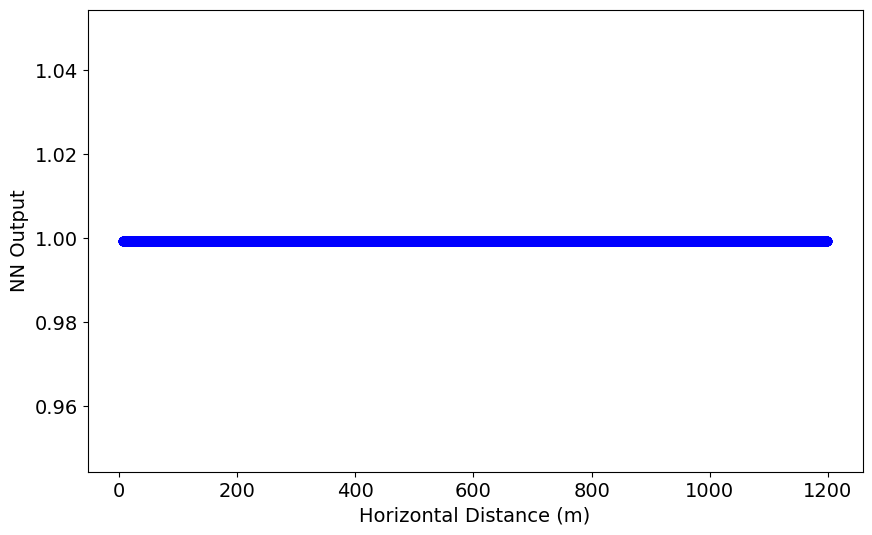

In [6]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
plt.scatter(test_data["Horizontal_Distance"], prediction, c="b", alpha=0.6)
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("NN Output")

In [7]:
test_data_2 = test_data.copy()
test_data_2["Throughput"] = test_data_2["Throughput"].values * 2
prediction2 = model.predict(test_data_2[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values * 100)

109/374 [=======>......................] - ETA: 0s

374/374 [==============================] - 0s 1ms/step


## Test AE On Single Scenario

In [51]:
LINK = "Downlink"
# model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/nn_checkpoints/djispark_throughput_anomaly_ae_dl/model.003-0.0000.h5", compile=False)
model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/nn_checkpoints/djispark_throughput_anomaly_small_ae_dl/model.001-0.0238.h5", compile=False)
model.compile(optimizer='adam', 
                loss='mse',
                metrics='mse')

# test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Test_Dataset_DJISpark_Throughput/data_processed/UAVSpeed-12_BitRate-26_Height-225_Distance-1200_Modulation-QAM-16_UAVSendingInterval-10/Downlink_Throughput.csv")
# test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/data_processed/UAVSpeed-6_BitRate-6.5_Height-270_Distance-1200_Modulation-BPSK_UAVSendingInterval-100/Downlink_Throughput.csv")
test_data = pd.DataFrame([{"Horizontal_Distance": 600, "Height": 270, "UAV_Sending_Interval": 100, 
                            "MCS_Index": 0, "UAV_Speed": 6, "Throughput": 14000}])
test_data[['Mean_SINR',"Std_Dev_SINR"]]= test_data.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
test_data["Throughput"] = test_data["Throughput"].values[0]/2
test_data = normalize_data(test_data, columns=["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK) 
prediction = model.predict(test_data[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values)

encoder_layer = model.get_layer('latent')
encoder = Model(inputs=model.input, outputs=encoder_layer.output)
latent = encoder.predict(test_data[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values)

1/1 [==============================] - 0s 36ms/step


In [53]:
test_data[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values

array([[-0.29670564, -0.5714736 ,  1.        , -1.        , -0.53846154,
        -0.125     ]])

In [54]:
prediction

array([[ 0.13144517, -0.0278399 ,  0.8730979 , -1.1847432 , -0.08189392,
         0.14763999]], dtype=float32)

In [50]:
latent

array([[5.043545  , 0.33518517, 1.9298681 ]], dtype=float32)

In [52]:
latent

array([[3.5730095 , 0.49085128, 1.651     ]], dtype=float32)

In [67]:
latent

array([[0.569029  , 0.43604743, 0.8780201 , 0.34280065, 0.44180983,
        0.2547969 , 0.3341884 , 0.04948578, 0.        , 0.91727346]],
      dtype=float32)

## Test NN AE Single Scenario

In [7]:
LINK = "Downlink"
# nn_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/nn_checkpoints/djispark_throughput_anomaly_nnv6_wobn_wae_dl/model.001-0.0000.h5", compile=False)
nn_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/nn_checkpoints/djispark_throughput_anomaly_nnv6_wobn_wae_dl/model.001-0.0000.h5", compile=False)
nn_model.compile(optimizer='adam', 
                loss='mse',
                metrics='mse')

ae_model = tf.keras.models.load_model("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/nn_checkpoints/djispark_throughput_anomaly_ae_dl/model.003-0.0000.h5", compile=False)
ae_model.compile(optimizer='adam', 
                loss='mse',
                metrics='mse')

# test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/Test_Dataset_DJISpark_Throughput/data_processed/UAVSpeed-12_BitRate-26_Height-225_Distance-1200_Modulation-QAM-16_UAVSendingInterval-10/Downlink_Throughput.csv")
# test_data = pd.read_csv("/media/research-student/One Touch/FANET Datasets/DJISpark_Measured_Throughput_10000Samples/data_processed/UAVSpeed-6_BitRate-6.5_Height-270_Distance-1200_Modulation-BPSK_UAVSendingInterval-100/Downlink_Throughput.csv")
test_data = pd.DataFrame([{"Horizontal_Distance": 300, "Height": 270, "UAV_Sending_Interval": 100, 
                            "MCS_Index": 0, "UAV_Speed": 6, "Throughput": 7000}])
test_data[['Mean_SINR',"Std_Dev_SINR"]]= test_data.apply(lambda row: sinr_lognormal_approx(row['Horizontal_Distance'],row['Height']),axis=1,result_type='expand')
# test_data["Throughput"] = test_data["Throughput"].values[0]/2
test_data = normalize_data(test_data, columns=["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"], link=LINK) 

encoder_layer = ae_model.get_layer('latent')
encoder = Model(inputs=ae_model.input, outputs=encoder_layer.output)
latent = encoder.predict(test_data[["Mean_SINR", "Std_Dev_SINR", "UAV_Sending_Interval", "MCS_Index", "UAV_Speed", "Throughput"]].values)

prediction = nn_model.predict(latent)

1/1 [==============================] - 0s 33ms/step


In [5]:
prediction

array([[1.]], dtype=float32)

In [6]:
latent

array([[1.4928604 , 0.8670732 , 1.1951435 , 0.60772175, 0.56106544,
        0.31622744, 0.4941975 , 0.10799679, 0.        , 1.5433528 ]],
      dtype=float32)

In [8]:
latent

array([[1.3520507 , 0.7229241 , 0.6155319 , 0.3409181 , 0.8674209 ,
        0.31777424, 0.3972127 , 0.14934264, 0.        , 1.2792591 ]],
      dtype=float32)